In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import *

Since for neural networks I will mostly use Pytorch, let's review few things about it. Let's create simple classification problem using Multiclass Logistic Regression, mini-batching, dimension reduction and normalization. I will use Iris Data set.

In [20]:
iris = load_iris()
X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

Next we will pre-process the data:

In [21]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', LDA(n_components=2))])
X_train=pipe.fit_transform(X_train, y_train)
X_test=pipe.transform(X_test)

In [22]:
#converting to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test)
train_ds = TensorDataset(X_train, y_train)
test_ds=TensorDataset(X_test, y_test)

#splitting into batches
batch_size = 20
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [23]:
n_samples, n_features = X_train.shape
lr=0.05
n_epoch= 500


Now we define model class:

In [24]:
class MultiClassLogisticRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        out = self.linear(x)
        return out

model = MultiClassLogisticRegression(num_features=n_features, num_classes=3)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
lossfunc=nn.CrossEntropyLoss()



In [25]:
for epoch in range(n_epoch):
    model.train()
    for x_batch, y_batch in train_dl:
        #### Compute outputs ####
        probas = model(x_batch)
        
        #### Compute gradients ####
        loss = lossfunc(probas, y_batch.long())
        optimizer.zero_grad()
        loss.backward()

        #### Update weights ####  
        optimizer.step()
   
    
    if (epoch+1)%100 ==0:
        model.eval()
        with torch.inference_mode(): 
            correct = 0
            total = 0
          
            # Compute the model's predictions 
            outputs = nn.functional.softmax(model(X_test) , dim=1)
            _, predicted = torch.max(outputs.data, 1) 
        
            # Compute the accuracy 
            total += y_test.size(0) 
            correct += (predicted == y_test).sum().item() 
            print(f'Epoch [{epoch}/{n_epoch}], Loss: {loss.item():.4f}, Test Accuracy: {100 * correct / total:.2f}')





Epoch [99/500], Loss: 0.1611, Test Accuracy: 86.67
Epoch [199/500], Loss: 0.0807, Test Accuracy: 93.33
Epoch [299/500], Loss: 0.0608, Test Accuracy: 96.67
Epoch [399/500], Loss: 0.1450, Test Accuracy: 100.00
Epoch [499/500], Loss: 0.1393, Test Accuracy: 100.00


One extra thing. Often we dont want to retrain our models everytime we have to use them. So it would be beneficial if we can save it and reload it when we need it. We really just need to save all parameters and type of model we used. Let's look at what we have:

In [26]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


print("\nOptimizer's state_dict: " )
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
  


Model's state_dict:
linear.weight 	 torch.Size([3, 2])
linear.bias 	 torch.Size([3])

Optimizer's state_dict: 
state 	 {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


Let's save these parameters

In [27]:
torch.save(model.state_dict(), '.\modelsavesample.pth')

Now let's reload the model and rerun the test set on it. Note that we saved only the parameters, so we need to create a new model and upload the parameters.

In [28]:
new_model=MultiClassLogisticRegression(num_features=n_features, num_classes=3)
new_model.load_state_dict(torch.load('modelsavesample.pth'))
new_model.eval()

MultiClassLogisticRegression(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [29]:
with torch.inference_mode(): 
    outputs=new_model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == y_test).sum().item()
    total += y_test.size(0)
    print(f'Test Accuracy: {100 * correct / total:.2f}')

Test Accuracy: 100.00


### Neural Networks

Developments of Neural Networks are not new. First ideas were concived in 1940-50's. Perceptron, which in essence is 1 layer neural network was created in 1960's. Backpropagation idea was invented in 1980's which made multilayer neural networks possible. And after 2000's more sophisticated neural networks were developed such as Convolutional NN, Recurrent NN, LSTM, etc.

If we look at above example, it is basically example of a shalow neural network:

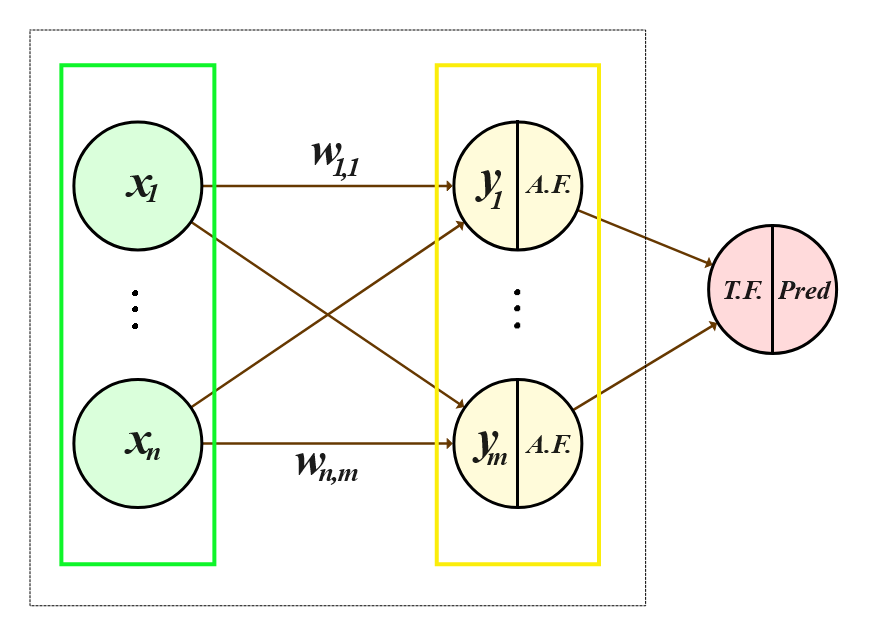

Here, green is an input layer, yellow is output layer. We have weights and biases (biases are not shown) between these two layers. We generally have some activation function (in this case it was softmax function). The results then generally plugged in the threshhold function (TF) to get predictions. We go through this graph forward (forward propagation), and then backward (back propagation) to find gradients that we will use to adjust our weights and biases.

Note that layers dont have to have the same amount of nodes. This will be true when we have more layers as well.

A deeper Neural Network will have hidden layers (layers in between input and putput layer). There are many types of neural networks. The simplest one is MLP (multi layer perceptron). It is an type of Feed-Forward NN, where information flows forward only. This is what it would look like:

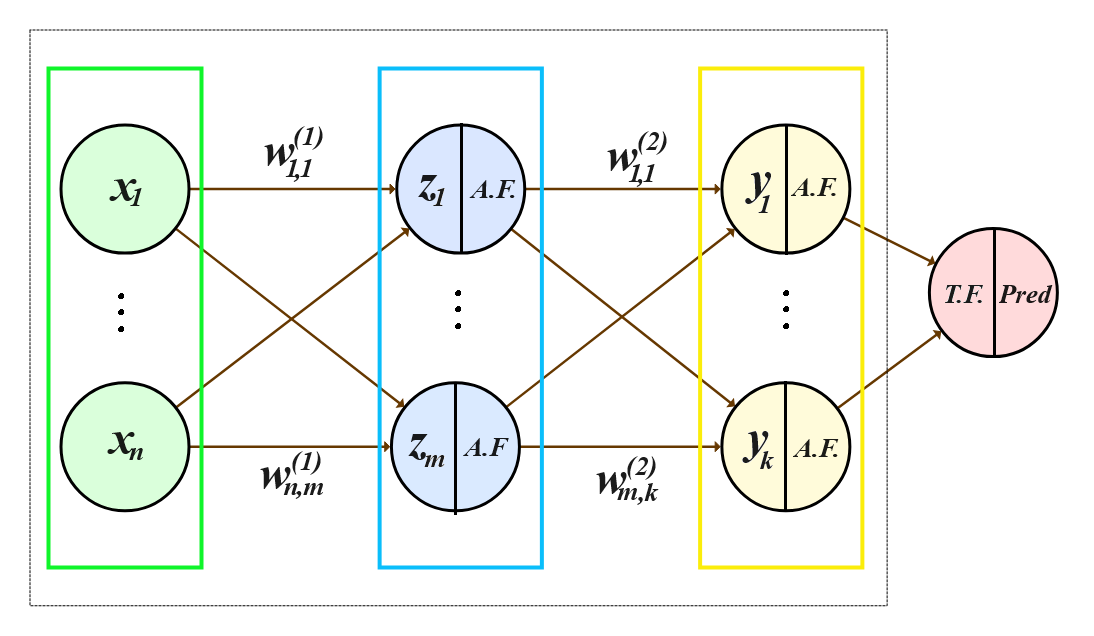

In the this case, blue layer is a hidden layer. Notice between weights between green and blue layer are not the same as weights between blue and yellow layer. Even activation functions in different layers dont have to be the same. Amount layers and amount of nodes in each layer can be anything. 

If leave our activation functions to be linear (like Adaline had), then having multiple layers becomes useless. This is because composition of linear functions is still linear and so nothing new happens from adding extra layers. To get a better flexibility we use non-linear activation functions. Most common ones are:

1. Sigmoid or softmax
2. Hyperbolic Tan
3. ReLU
4. Leaky ReLU

Here are examples of them:

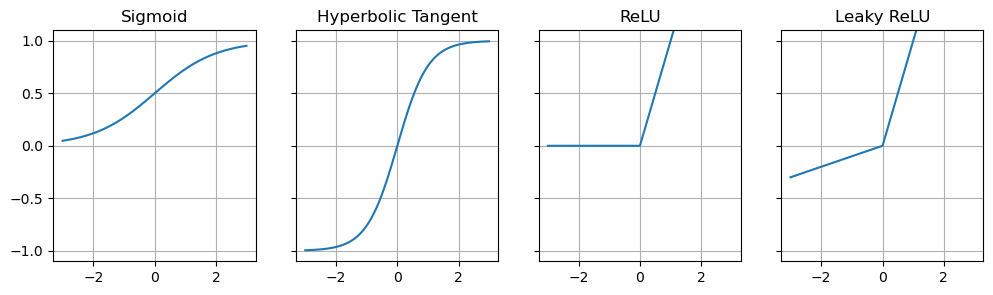

In [30]:
sigm=lambda x: 1/(1+np.exp(-x))
HypTan= lambda x: np.tanh(x)   
Relu=lambda x: np.maximum(0,x)
LeRelu=lambda x: np.maximum(0.1*x, x)

fig, ax=plt.subplots(1,4, figsize=(12,3), sharey=True)
x=np.arange(-3, 3, 0.01)
ax[0].plot(x, sigm(x))
ax[1].plot(x, HypTan(x))
ax[2].plot(x,Relu(x))
ax[3].plot(x,LeRelu(x))

ax[0].set_title('Sigmoid')
ax[0].grid()
ax[1].set_title('Hyperbolic Tangent')
ax[1].grid()
ax[2].set_title('ReLU')
ax[2].grid()
ax[3].set_title('Leaky ReLU')
ax[3].grid()
plt.ylim(-1.1, 1.1)

plt.show()

Few notes regarding specific activation functions:

1. Sigmoid:
   
   a. (-) When values get larger than 3 in absolute value, gradient will get very small leading to Vanishing Gradient Problem (discussed below).
   
   b. (-) Not symmetric around zero (all values are positive).
   
   c. (+) Differentiable.
   
2. Softmax: generally used in the last layer, since between layers we keep node independent, so Sigmoid is more appropriate.
   
3. Hyperbolic Tangent:
   
   a. (-) Vanishing Gradient Problem after values around 4 as well.
   
   b. (+) Centered around zero.
   
   c. (+) Differetiable.
   
4. ReLU (Rectified Linear Unit):
   
   a. (+) Doesn't activate all neurons (more efficient).
   
   b. (+) Faster convergence to global minimum of loss function.
   
   c. (-) Some neurons die since gradient becomes zero for negative values.

   d. (+) Computationally very simple.
   
6. Leaky ReLU:
    
   a. (+) Fixes dead neuron problem of ReLU.
   
   b. (-) More time consuming than ReLU

There are a lot of other activativation functions with their advantages and disadvantages (ELU, GELU, SELU, Swish, etc). The choice depends on your neural network, your dataset, your goals, etc.

Vanishing Gradient Problem: certain activation functions may lead to vanishing gradient problem. In each layer, the gradient may become very small and as we backpropagate, due to chain rule, we multiply gradients as we go back, so the resulting gradient becomes practically zero and so weights are not going to get uopdated.

Which activation should we use? Generally ReLU is a good start for hidden layers. Sigmoid, Softmax, Hyperbolic Tan are better for final layer (though they can be used in hidden layers in certain types of neural networks like RNN). If your neural network get very deep, you might want to explore more advanced activation functions. 

Let's now create a simple Neural Network with 1 hidden layer:

In [31]:
n_samples, n_features = X_train.shape
n_hidden=3
lr=0.05
n_epoch= 500

In [32]:
class mlp(torch.nn.Module):

    def __init__(self, num_features, n_hidden, num_classes):
        super(mlp, self).__init__()
        self.linear1 = torch.nn.Linear(num_features, n_hidden)
        self.relu=nn.ReLU()
        self.linear2=torch.nn.Linear(n_hidden,num_classes)
    
    def forward(self, x):
        out = self.linear1(x)
        out=self.relu(out)
        out=self.linear2(out)
        return out

model2 = mlp(num_features=n_features, n_hidden=n_hidden, num_classes=3)
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
lossfunc=nn.CrossEntropyLoss()


In [33]:
for epoch in range(n_epoch):
    model2.train()
    for x_batch, y_batch in train_dl:
        #### Compute outputs ####
        probas = model2(x_batch)
        
        #### Compute gradients ####
        loss = lossfunc(probas, y_batch.long())
        optimizer.zero_grad()
        loss.backward()

        #### Update weights ####  
        optimizer.step()
   
    model2.eval()
    if (epoch)%100 ==99:
        with torch.inference_mode(): 
            correct = 0
            total = 0
          
            # Compute the model's predictions 
            outputs = nn.functional.softmax(model2(X_test) , dim=1)
            _, predicted = torch.max(outputs.data, 1) 
        
            # Compute the accuracy 
            total += y_test.size(0) 
            correct += (predicted == y_test).sum().item() 
            print(f'Epoch [{epoch}/{n_epoch}], Loss: {loss.item():.4f}, Test Accuracy: {100 * correct / total:.2f}')

Epoch [99/500], Loss: 0.1509, Test Accuracy: 93.33
Epoch [199/500], Loss: 0.0438, Test Accuracy: 100.00
Epoch [299/500], Loss: 0.0245, Test Accuracy: 100.00
Epoch [399/500], Loss: 0.0304, Test Accuracy: 100.00
Epoch [499/500], Loss: 0.0372, Test Accuracy: 100.00


In [34]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary_torch(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', '^', 'o', 'x', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

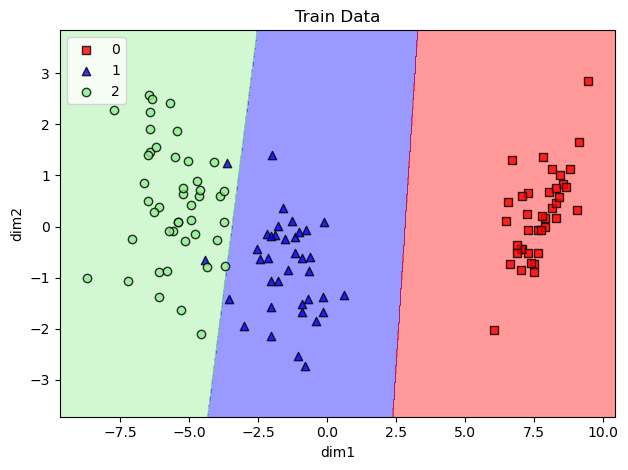

In [35]:
plot_decision_boundary_torch(X_train, y_train, classifier=model2)
plt.title("Train Data")
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()